# Human vs Model UX Assessment Comparison

This notebook compares human evaluations with model evaluations for dark patterns, focusing on UX KPI metrics and pattern assessments.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import os

# Set up visual style
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

# Create output directory
output_dir = "results-noleakage-eval_output"
input_dir = "results-noleakage"
os.makedirs(output_dir, exist_ok=True)

## Load Data

First, let's load both human evaluations and model evaluations.

In [2]:
# Load human data
human_data = pd.read_csv("Formatting Human Survey Data/raw_participant_evaluations.csv")

# Fix column name for consistency
if 'score_addictive_non-addictive' in human_data.columns:
    human_data = human_data.rename(columns={'score_addictive_non-addictive': 'score_addictive_non_addictive'})

# Add data source column
human_data['data_source'] = 'Human'

print(f"Human data shape: {human_data.shape}")
human_data.head()

Human data shape: (443, 19)


,metadata_participant_id,metadata_timestamp,metadata_pattern_type,metadata_interface_id,score_inefficient_efficient,score_interesting_not_interesting,score_clear_confusing,score_enjoyable_annoying,score_organized_cluttered,score_addictive_non_addictive,score_supportive_obstructive,score_pressuring_suggesting,score_boring_exciting,score_revealed_covert,score_complicated_easy,score_unpredictable_predictable,score_friendly_unfriendly,score_deceptive_benevolent,data_source
0,P219,2025-04-07T14:38:54,Overcomplicated Process,interface_002,6,2,2,2,3,4,3,4,3,3,6,5,5,5,Human
1,P219,2025-04-07T14:38:56,Sneaking Bad Default,interface_004,4,1,3,5,2,5,4,5,4,1,6,4,4,3,Human
2,P219,2025-04-07T14:38:58,False Hierarchy,interface_006,3,3,3,6,5,4,6,1,-1,2,7,5,6,3,Human
3,P219,2025-04-07T14:38:00,Toying With Emotion,interface_008,5,3,6,6,2,2,7,1,4,3,4,6,7,2,Human
4,P219,2025-04-07T14:38:06,Endlessness,interface_014,3,1,4,3,3,1,5,4,5,2,6,2,4,2,Human


In [3]:
# Load model data (combining all model results)
model_files = [
    f for f in os.listdir(input_dir) 
    if f.endswith('.csv') and not f.endswith('_log.csv') and f != 'api_usage.csv'
]
model_files = [os.path.join(input_dir, f) for f in model_files]

# Print the files we're processing
print(f"Processing {len(model_files)} model result files:")

# Group files by model type for better analysis
qwen_files = [f for f in model_files if 'qwen' in f.lower()]
openai_files = [f for f in model_files if 'openai' in f.lower() or 'gpt' in f.lower()]
ollama_files = [f for f in model_files if 'ollama' in f.lower()]
anthropic_files = [f for f in model_files if 'anthropic' in f.lower() or 'claude' in f.lower()]
other_files = [f for f in model_files if f not in qwen_files + openai_files + anthropic_files + ollama_files]

print(f"- Found {len(qwen_files)} Qwen files")
print(f"- Found {len(openai_files)} OpenAI files")
print(f"- Found {len(anthropic_files)} Anthropic files")
print(f"- Found {len(ollama_files)} Ollama files")
print(f"- Found {len(other_files)} Other files")

model_data_list = []
for file in model_files:
    try:
        # First try normal loading
        df = pd.read_csv(file)
        # Check if first row contains statistical headers
        if any(col in str(df.iloc[0]).lower() for col in ['mean', 'std']):
            print(f"File {file} has statistical headers, skipping first row")
            df = pd.read_csv(file, skiprows=1)
        
        # For Qwen files, force the correct values
        if 'qwen' in file.lower():
            df['metadata_ai_service'] = 'qwen'
            df['metadata_model'] = 'qwen-vl-max'
        elif 'openai' in file.lower() or 'gpt' in file.lower():
            df['metadata_ai_service'] = 'openai'
            df['metadata_model'] = 'gpt-4-turbo'  
        elif 'anthropic' in file.lower() or 'claude' in file.lower():
            df['metadata_ai_service'] = 'anthropic'
            df['metadata_model'] = 'claude-3-opus-20240229'
            
        # Check if necessary columns exist
        if 'metadata_pattern_type' not in df.columns:
            print(f"Skipping {file} - missing metadata_pattern_type column")
            continue
            
        # Keep only essential columns to avoid timestamp columns that can't be averaged
        essential_cols = [col for col in df.columns if (
            col.startswith('metadata_') or 
            col.startswith('score_') or
            col == 'explanation'
        )]
        
        # Skip files without necessary columns
        if not any(col.startswith('score_') for col in essential_cols):
            print(f"Skipping {file} - missing score columns")
            continue
            
        df = df[essential_cols]
        
        # Ensure service and model columns exist
        if 'metadata_ai_service' not in df.columns:
            print(f"Adding missing metadata_ai_service to {file}")
            if 'qwen' in file.lower():
                df['metadata_ai_service'] = 'qwen'
            elif 'openai' in file.lower() or 'gpt' in file.lower():
                df['metadata_ai_service'] = 'openai'
            elif 'anthropic' in file.lower() or 'claude' in file.lower():
                df['metadata_ai_service'] = 'anthropic'
                
        if 'metadata_model' not in df.columns:
            print(f"Adding missing metadata_model to {file}")
            if 'qwen' in file.lower():
                df['metadata_model'] = 'qwen-vl-max'
            elif 'gpt-4' in file.lower():
                df['metadata_model'] = 'gpt-4-turbo'
            elif 'claude' in file.lower():
                df['metadata_model'] = 'claude-3-opus-20240229'
        
        # Ensure consistent data types for score columns
        for col in df.columns:
            if col.startswith('score_'):
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Verify we have the core columns we need
        if 'metadata_pattern_type' in df.columns and 'metadata_ai_service' in df.columns and 'metadata_model' in df.columns:
            # Print a sample of the models in this file
            sample_service = df['metadata_ai_service'].iloc[0] if not df.empty else "unknown"
            sample_model = df['metadata_model'].iloc[0] if not df.empty else "unknown"
            print(f"Loaded {len(df)} rows from {file} - Service: {sample_service}, Model: {sample_model}")
            model_data_list.append(df)
        else:
            print(f"Skipping {file} - missing required metadata columns")
            
    except Exception as e:
        print(f"Error reading {file}: {e}")

# Combine all model data
if model_data_list:
    model_data = pd.concat(model_data_list, ignore_index=True)
    
    # Fix column name for consistency
    if 'score_addictive_non-addictive' in model_data.columns:
        model_data = model_data.rename(columns={'score_addictive_non-addictive': 'score_addictive_non_addictive'})
    
    # Add data source column
    model_data['data_source'] = 'AI Model'
    
    # Summary of loaded models
    model_summary = model_data.groupby(['metadata_ai_service', 'metadata_model']).size().reset_index()
    model_summary.columns = ['Service', 'Model', 'Count']
    print("\nModels loaded:")
    print(model_summary)
    
    print(f"\nModel data shape: {model_data.shape}")
    print("Sample of loaded data for each service:")
    for service in model_data['metadata_ai_service'].unique():
        sample = model_data[model_data['metadata_ai_service'] == service]
        print(f"\n{service} - {len(sample)} rows:")
        print(sample[['metadata_ai_service', 'metadata_model', 'metadata_pattern_type']].head(2))
else:
    print("No valid model data files found!")
    model_data = pd.DataFrame()  # Create empty DataFrame to avoid errors

Processing 24 model result files:
- Found 6 Qwen files
- Found 6 OpenAI files
- Found 6 Anthropic files
- Found 6 Ollama files
- Found 0 Other files
Loaded 15 rows from results-noleakage/results_anthropic_claude_3_opus_20240229_temp0.7_run1_20250408_142415.csv - Service: anthropic, Model: claude-3-opus-20240229
Loaded 15 rows from results-noleakage/results_anthropic_claude_3_opus_20240229_temp0.7_run3_20250408_142415.csv - Service: anthropic, Model: claude-3-opus-20240229
Loaded 15 rows from results-noleakage/results_anthropic_claude_3_opus_20240229_temp0.7_run2_20250408_142415.csv - Service: anthropic, Model: claude-3-opus-20240229
Loaded 15 rows from results-noleakage/results_qwen_qwen_vl_max_temp0.7_run2_20250408_142415.csv - Service: qwen, Model: qwen-vl-max
Loaded 15 rows from results-noleakage/results_qwen_qwen_vl_max_temp0.7_run3_20250408_142415.csv - Service: qwen, Model: qwen-vl-max
Loaded 15 rows from results-noleakage/results_qwen_qwen_vl_max_temp0.7_run1_20250408_142415.csv

## Calculate UX KPI

Calculate the UX KPI for both human and model assessments based on negative UX aspects.

In [4]:
def calculate_ux_kpi(df):
    """Calculate UX KPI based on negative UX aspects with normalized -3 to +3 scale."""
    # Create a copy to avoid modifying the input
    result_df = df.copy()
    
    # Fix the addictive column name for consistency
    if 'score_addictive_non-addictive' in result_df.columns and 'score_addictive_non_addictive' not in result_df.columns:
        result_df['score_addictive_non_addictive'] = result_df['score_addictive_non-addictive']
    
    # Define UX KPI components
    ux_kpi_items = {
        'boring': 'score_boring_exciting',           # Low = boring
        'not_interesting': 'score_interesting_not_interesting',  # High = not interesting
        'complicated': 'score_complicated_easy',     # Low = complicated
        'confusing': 'score_clear_confusing',        # High = confusing
        'inefficient': 'score_inefficient_efficient', # Low = inefficient
        'cluttered': 'score_organized_cluttered',     # High = cluttered
        'unpredictable': 'score_unpredictable_predictable', # Low = unpredictable
        'obstructive': 'score_supportive_obstructive'  # High = obstructive
    }
    
    # Define all UEQ scales for worst aspect detection with their directions
    all_ueq_items = {
        # UX KPI items
        'boring': 'score_boring_exciting',           # Low = boring
        'not_interesting': 'score_interesting_not_interesting',  # High = not interesting
        'complicated': 'score_complicated_easy',     # Low = complicated
        'confusing': 'score_clear_confusing',        # High = confusing
        'inefficient': 'score_inefficient_efficient', # Low = inefficient
        'cluttered': 'score_organized_cluttered',     # High = cluttered
        'unpredictable': 'score_unpredictable_predictable', # Low = unpredictable
        'obstructive': 'score_supportive_obstructive',  # High = obstructive
        
        # Additional UEQ scales
        'annoying': 'score_enjoyable_annoying',      # High = annoying
        'pressuring': 'score_pressuring_suggesting', # Low = pressuring
        'covert': 'score_revealed_covert',           # High = covert
        'unfriendly': 'score_friendly_unfriendly',   # High = unfriendly
        'deceptive': 'score_deceptive_benevolent',   # Low = deceptive
        'addictive': 'score_addictive_non_addictive' # Low = addictive
    }
    
    # Define which items need to be inverted (where higher score = better UX)
    needs_inversion = [
        'boring', 'complicated', 'inefficient', 'unpredictable', 
        'pressuring', 'deceptive', 'addictive'
    ]
    
    # First, create normalized scores (-3 to +3 scale instead of 1-7)
    for ueq_item, column in all_ueq_items.items():
        if column in result_df.columns:
            # Convert 1-7 scale to -3 to +3 scale where 0 is neutral
            result_df[f'norm_{column}'] = result_df[column] - 4
    
    # Create standardized values (higher = worse UX) on the -3 to +3 scale
    # First handle UX KPI items for UX KPI calculation
    for ux_item, column in ux_kpi_items.items():
        if column in result_df.columns:
            norm_col = f'norm_{column}'
            if ux_item in needs_inversion:
                # These need to be inverted so high values = negative aspect
                result_df[f'ux_{ux_item}'] = -result_df[norm_col]  # invert sign
            else:
                # These are already oriented so high values = negative aspect
                result_df[f'ux_{ux_item}'] = result_df[norm_col]
    
    # Calculate UX KPI (mean of KPI items only)
    ux_items = [f'ux_{item}' for item in ux_kpi_items.keys() if f'ux_{item}' in result_df.columns]
    
    if ux_items:
        result_df['ux_kpi'] = result_df[ux_items].mean(axis=1)
    
    # Now create standardized values for ALL UEQ scales for worst aspect detection
    for ueq_item, column in all_ueq_items.items():
        if column in result_df.columns:
            norm_col = f'norm_{column}'
            # Check if this item needs to be inverted
            if ueq_item in needs_inversion:
                # These need to be inverted so high values = negative aspect
                result_df[f'std_{ueq_item}'] = -result_df[norm_col]  # invert sign
            else:
                # These are already oriented so high values = negative aspect
                result_df[f'std_{ueq_item}'] = result_df[norm_col]
    
    # Determine worst aspect from ALL UEQ scales
    std_items = [f'std_{item}' for item in all_ueq_items.keys() if f'std_{item}' in result_df.columns]
    
    if std_items:
        # Find the worst aspect (highest value is worst)
        result_df['worst_aspect'] = result_df[std_items].idxmax(axis=1).str.replace('std_', '')
        result_df['worst_value'] = result_df[std_items].max(axis=1)
    
    return result_df

# Calculate UX KPI for human data
human_data_with_kpi = calculate_ux_kpi(human_data)

# Calculate UX KPI for model data
model_data_with_kpi = calculate_ux_kpi(model_data)

# Show sample results
print("Human Data with UX KPI (normalized -3 to +3 scale):")
print(human_data_with_kpi[['metadata_pattern_type', 'ux_kpi', 'worst_aspect', 'worst_value']].head())

print("\nModel Data with UX KPI (normalized -3 to +3 scale):")
print(model_data_with_kpi[['metadata_pattern_type', 'metadata_ai_service', 'metadata_model', 'ux_kpi', 'worst_aspect', 'worst_value']].head())

# Double-check direction consistency between human and model data
print("\nDirection check - standardized values for first human entry (should be between -3 and +3):")
std_cols = [col for col in human_data_with_kpi.columns if col.startswith('std_')]
print(human_data_with_kpi.iloc[0][std_cols])

print("\nDirection check - standardized values for first model entry (should be between -3 and +3):")
std_cols = [col for col in model_data_with_kpi.columns if col.startswith('std_')]
print(model_data_with_kpi.iloc[0][std_cols])

Human Data with UX KPI (normalized -3 to +3 scale):
     metadata_pattern_type  ux_kpi worst_aspect  worst_value
0  Overcomplicated Process  -1.250       boring            1
1     Sneaking Bad Default  -1.000     annoying            1
2          False Hierarchy   0.375       boring            5
3      Toying With Emotion  -0.125  obstructive            3
4              Endlessness  -0.375    addictive            3

Model Data with UX KPI (normalized -3 to +3 scale):
         metadata_pattern_type metadata_ai_service          metadata_model  \
0                      Nagging           anthropic  claude-3-opus-20240229   
1      Overcomplicated Process           anthropic  claude-3-opus-20240229   
2   Hindering Account Deletion           anthropic  claude-3-opus-20240229   
3         Sneaking Bad Default           anthropic  claude-3-opus-20240229   
4  Expectation Result Mismatch           anthropic  claude-3-opus-20240229   

   ux_kpi     worst_aspect  worst_value  
0   0.125      com

## Compare Human and Model Assessments

Now let's generate a comparison of the average UX KPI for each pattern type between humans and models.

In [5]:
# Calculate average UX KPI for each pattern type - Human data
human_pattern_kpi = human_data_with_kpi.groupby('metadata_pattern_type')['ux_kpi'].mean().reset_index()
human_pattern_kpi = human_pattern_kpi.rename(columns={'ux_kpi': 'human_ux_kpi'})

# Fix the "Pull to Refresh" and "Pull To Refresh" inconsistency
human_pattern_kpi['metadata_pattern_type'] = human_pattern_kpi['metadata_pattern_type'].replace('Pull to Refresh', 'Pull To Refresh')

# Calculate average UX KPI for each pattern type and model
model_pattern_kpi = model_data_with_kpi.groupby(['metadata_pattern_type', 'metadata_ai_service', 'metadata_model'])['ux_kpi'].mean().reset_index()
# Fix pattern names in model data
model_pattern_kpi['metadata_pattern_type'] = model_pattern_kpi['metadata_pattern_type'].replace('Pull to Refresh', 'Pull To Refresh')

# Print summary of models in the model pattern KPI data
print("Models in model_pattern_kpi:")
print(model_pattern_kpi[['metadata_ai_service', 'metadata_model']].drop_duplicates())

# Create separate columns for each model
model_comparison_data = human_pattern_kpi.copy()

# Add each model's data as a separate column
for service in model_data_with_kpi['metadata_ai_service'].unique():
    if pd.isna(service):
        continue
        
    for model in model_data_with_kpi[model_data_with_kpi['metadata_ai_service'] == service]['metadata_model'].unique():
        if pd.isna(model):
            continue
            
        # Print for debugging
        print(f"Adding {service} {model} data to comparison")
            
        # Filter for this service/model
        filter_mask = (model_pattern_kpi['metadata_ai_service'] == service) & (model_pattern_kpi['metadata_model'] == model)
        model_data_subset = model_pattern_kpi[filter_mask]
        
        # Skip if no data for this model
        if len(model_data_subset) == 0:
            print(f"No data for {service} {model}, skipping")
            continue
            
        # Print number of patterns for this model
        print(f"  Found {len(model_data_subset)} patterns for {service} {model}")
        
        # Rename column and merge
        model_data_subset = model_data_subset.rename(columns={'ux_kpi': f'{service}_{model}'})
        model_comparison_data = model_comparison_data.merge(
            model_data_subset[['metadata_pattern_type', f'{service}_{model}']],
            on='metadata_pattern_type',
            how='left'
        )

# Sort by human UX KPI (worst to best)
combined_kpi = model_comparison_data.sort_values('human_ux_kpi', ascending=False)

# Display comparison table
print("\nUX KPI Comparison (Higher values = Worse UX):")
combined_kpi

Models in model_pattern_kpi:
  metadata_ai_service          metadata_model
0           anthropic  claude-3-opus-20240229
1              ollama                  gemma3
2              openai             gpt-4-turbo
3                qwen             qwen-vl-max
Adding anthropic claude-3-opus-20240229 data to comparison
  Found 15 patterns for anthropic claude-3-opus-20240229
Adding qwen qwen-vl-max data to comparison
  Found 15 patterns for qwen qwen-vl-max
Adding openai gpt-4-turbo data to comparison
  Found 15 patterns for openai gpt-4-turbo
Adding ollama gemma3 data to comparison
  Found 15 patterns for ollama gemma3

UX KPI Comparison (Higher values = Worse UX):


,metadata_pattern_type,human_ux_kpi,anthropic_claude-3-opus-20240229,qwen_qwen-vl-max,openai_gpt-4-turbo,ollama_gemma3
4,Forced Access,0.669355,1.187500,0.500000,0.541667,-0.083333
2,Expectation Result Mismatch,0.582031,1.166667,0.416667,-0.583333,0.000000
7,Nagging,0.572917,-1.208333,0.250000,-0.583333,0.000000
8,Overcomplicated Process,0.535714,-0.875000,0.020833,0.000000,0.000000
14,Trick Wording,0.446429,-1.208333,0.041667,-0.520833,-0.375000
3,False Hierarchy,0.399194,-0.979167,0.166667,-0.312500,0.000000
13,Toying With Emotion,0.135000,-1.750000,-0.083333,-1.041667,-0.208333
5,Gamification,-0.058036,-1.166667,0.250000,-0.312500,0.000000
0,Content Customization,-0.189655,-0.895833,0.333333,-0.520833,0.000000
11,Social Connector,-0.341667,-1.520833,0.125000,-0.291667,-0.062500


## Visualize the Comparison

Let's create a bar chart to compare human vs. model average UX KPI for each pattern type.

Model Pattern KPI data:
Shape: (60, 4)
Services and models:
  metadata_ai_service          metadata_model
0           anthropic  claude-3-opus-20240229
1              ollama                  gemma3
2              openai             gpt-4-turbo
3                qwen             qwen-vl-max

Pattern counts by source:
source
Human        15
anthropic    15
ollama       15
openai       15
qwen         15
Name: pattern_type, dtype: int64


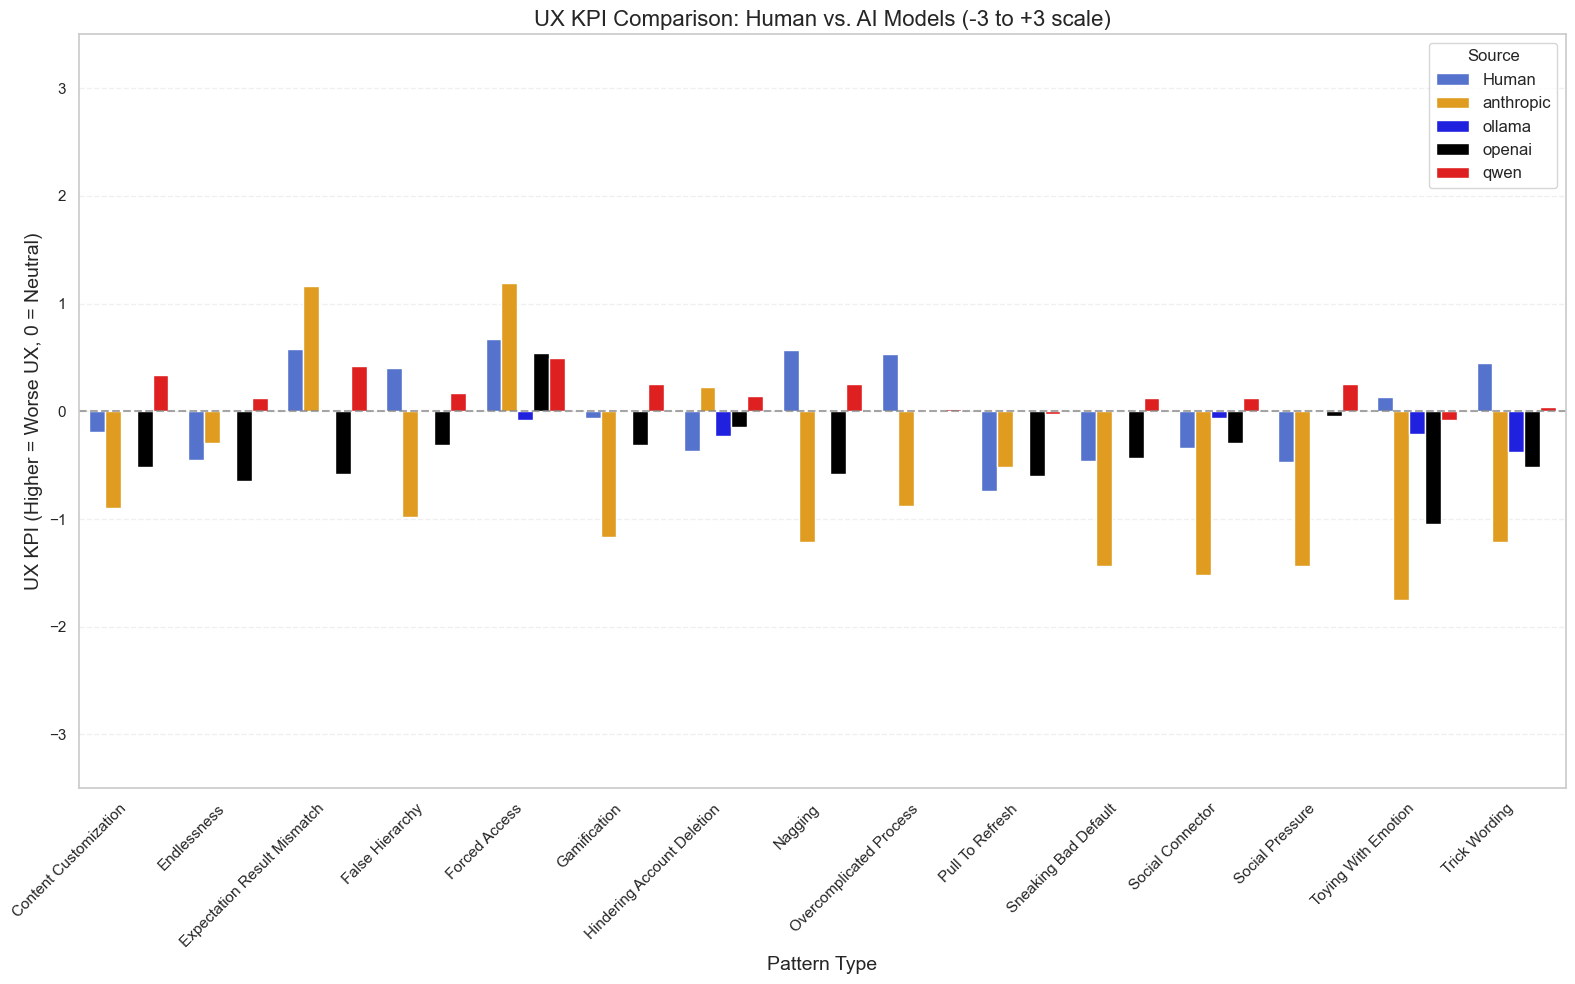

In [6]:
# Prepare data for visualization
# Create a long-format dataframe for easier plotting
comparison_data = []

# Add human data
for idx, row in human_pattern_kpi.iterrows():
    pattern = row['metadata_pattern_type']
    comparison_data.append({
        'pattern_type': pattern,
        'source': 'Human',
        'model': 'Human',
        'ux_kpi': row['human_ux_kpi']
    })

# Print out model_pattern_kpi info for debugging
print("Model Pattern KPI data:")
print(f"Shape: {model_pattern_kpi.shape}")
print("Services and models:")
print(model_pattern_kpi[['metadata_ai_service', 'metadata_model']].drop_duplicates())

# Add model data directly from model_pattern_kpi
for idx, row in model_pattern_kpi.iterrows():
    pattern = row['metadata_pattern_type']
    service = row['metadata_ai_service']
    model = row['metadata_model']
    
    comparison_data.append({
        'pattern_type': pattern,
        'source': service,
        'model': model,
        'ux_kpi': row['ux_kpi']
    })

comparison_df = pd.DataFrame(comparison_data)

# Count patterns by source for verification
print("\nPattern counts by source:")
source_counts = comparison_df.groupby('source')['pattern_type'].count()
print(source_counts)

# Fix the "Pull to Refresh" and "Pull To Refresh" inconsistency
comparison_df['pattern_type'] = comparison_df['pattern_type'].replace('Pull to Refresh', 'Pull To Refresh')

# Create bar chart with specific color palette for each model
plt.figure(figsize=(16, 10))

# Set up a clear color palette
palette = {'Human': 'royalblue', 'openai': 'black', 'anthropic': 'orange', 'qwen': 'red', 'ollama': 'blue'}

# Create the bar plot
ax = sns.barplot(x='pattern_type', y='ux_kpi', hue='source', data=comparison_df, palette=palette)

# Add a horizontal line at y=0 (neutral)
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)

# Customize chart
plt.title('UX KPI Comparison: Human vs. AI Models (-3 to +3 scale)', fontsize=16)
plt.xlabel('Pattern Type', fontsize=14)
plt.ylabel('UX KPI (Higher = Worse UX, 0 = Neutral)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Source', fontsize=12)

# Set y-axis limits to show the full -3 to +3 range
plt.ylim(-3.5, 3.5)  

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()

# Save figure
plt.savefig(os.path.join(output_dir, 'human_model_ux_kpi_comparison_normalized.png'))
plt.show()

## Create Gauge Visualizations

Now let's create gauge visualizations for both human and model assessments.

In [7]:
# Calculate UX metrics by pattern for human data
human_pattern_avg = human_data_with_kpi.groupby('metadata_pattern_type').agg({
    'ux_kpi': 'mean',
    'worst_aspect': lambda x: x.mode()[0] if not x.mode().empty else None,
    'worst_value': 'mean'
}).reset_index()

# Fix the "Pull to Refresh" and "Pull To Refresh" inconsistency
human_pattern_avg['metadata_pattern_type'] = human_pattern_avg['metadata_pattern_type'].replace('Pull to Refresh', 'Pull To Refresh')

# Show all UEQ scores for each pattern
pattern_scores = {}

# Get all standardized metric columns (std_*)
std_cols = [col for col in human_data_with_kpi.columns if col.startswith('std_')]

# Calculate mean scores for each metric by pattern type
for pattern, group in human_data_with_kpi.groupby('metadata_pattern_type'):
    # Calculate mean for each standardized UEQ metric
    metric_means = {}
    for col in std_cols:
        metric = col.replace('std_', '')
        metric_means[metric] = group[col].mean()
    
    pattern_scores[pattern] = metric_means

# Convert to DataFrame for easier viewing
pattern_scores_df = pd.DataFrame.from_dict(pattern_scores, orient='index')

# Sort metrics from worst to best for each pattern
pattern_ranking = {}
for pattern in pattern_scores:
    # Sort metrics by score (higher = worse)
    sorted_metrics = sorted(pattern_scores[pattern].items(), key=lambda x: x[1], reverse=True)
    pattern_ranking[pattern] = sorted_metrics

# Print worst aspects for each pattern
print("Top 3 worst aspects for each pattern (from all UEQ scales):")
for pattern, metrics in pattern_ranking.items():
    if len(metrics) >= 3:
        print(f"{pattern}: {metrics[0][0]} ({metrics[0][1]:.2f}), {metrics[1][0]} ({metrics[1][1]:.2f}), {metrics[2][0]} ({metrics[2][1]:.2f})")

# Save human pattern metrics to CSV 
human_metrics_path = os.path.join(output_dir, 'human_pattern_metrics.csv')
human_pattern_avg.to_csv(human_metrics_path, index=False)

# Save full UEQ scores by pattern
pattern_scores_df.to_csv(os.path.join(output_dir, 'human_pattern_all_metrics.csv'))
print(f"Human pattern metrics saved to {human_metrics_path}")
print(f"Human pattern UEQ scores saved to {os.path.join(output_dir, 'human_pattern_all_metrics.csv')}")

Top 3 worst aspects for each pattern (from all UEQ scales):
Content Customization: pressuring (0.48), deceptive (0.45), boring (0.21)
Endlessness: addictive (1.21), deceptive (0.75), pressuring (0.61)
Expectation Result Mismatch: confusing (1.31), deceptive (1.19), cluttered (1.12)
False Hierarchy: pressuring (2.06), deceptive (2.03), unfriendly (1.94)
Forced Access: pressuring (1.48), deceptive (1.48), annoying (1.42)
Gamification: pressuring (1.57), addictive (0.89), deceptive (0.79)
Hindering Account Deletion: pressuring (0.38), annoying (0.28), boring (0.24)
Nagging: obstructive (1.83), pressuring (1.83), annoying (1.75)
Overcomplicated Process: confusing (0.94), cluttered (0.86), unfriendly (0.83)
Pull To Refresh: addictive (0.81), pressuring (0.15), boring (-0.15)
Sneaking Bad Default: annoying (0.72), pressuring (0.59), unfriendly (0.44)
Social Connector: pressuring (0.87), deceptive (0.87), boring (0.57)
Social Pressure: pressuring (0.97), addictive (0.85), not_interesting (0.6

In [8]:
# Calculate model pattern metrics
model_pattern_metrics = {}

for service in model_data_with_kpi['metadata_ai_service'].unique():
    for model in model_data_with_kpi[model_data_with_kpi['metadata_ai_service'] == service]['metadata_model'].unique():
        # Filter data for this model
        model_filter = (model_data_with_kpi['metadata_ai_service'] == service) & \
                       (model_data_with_kpi['metadata_model'] == model)
        this_model_data = model_data_with_kpi[model_filter]
        
        # Normalize pattern names
        this_model_data['metadata_pattern_type'] = this_model_data['metadata_pattern_type'].replace('Pull to Refresh', 'Pull To Refresh')
        
        # Calculate average ux values, worst aspect, and UX KPI for each pattern type
        model_pattern_avg = this_model_data.groupby('metadata_pattern_type').agg({
            'ux_kpi': 'mean',
            'worst_aspect': lambda x: x.mode()[0] if not x.mode().empty else None,
            'worst_value': 'mean'
        }).reset_index()
        
        # Save to dictionary
        model_pattern_metrics[f"{service}_{model}"] = model_pattern_avg
        
        # Get all standardized metric columns (std_*)
        std_cols = [col for col in this_model_data.columns if col.startswith('std_')]
        
        # Calculate and show detailed UEQ metrics
        pattern_scores = {}
        
        for pattern, group in this_model_data.groupby('metadata_pattern_type'):
            # Calculate mean for each standardized UEQ metric
            metric_means = {}
            for col in std_cols:
                metric = col.replace('std_', '')
                metric_means[metric] = group[col].mean()
            
            pattern_scores[pattern] = metric_means
        
        # Convert to DataFrame for easier viewing
        pattern_scores_df = pd.DataFrame.from_dict(pattern_scores, orient='index')
        
        # Print worst aspects for a sample pattern
        if len(pattern_scores) > 0:
            sample_pattern = list(pattern_scores.keys())[0]
            sorted_metrics = sorted(pattern_scores[sample_pattern].items(), key=lambda x: x[1], reverse=True)
            print(f"\n{service} {model} worst aspects for {sample_pattern}:")
            for metric, value in sorted_metrics[:3]:
                print(f"  {metric}: {value:.2f}")
        
        # Save to CSV
        model_metrics_path = os.path.join(output_dir, f'{service}_{model}_pattern_metrics.csv')
        model_pattern_avg.to_csv(model_metrics_path, index=False)
        
        # Save full UEQ scores
        detailed_metrics_path = os.path.join(output_dir, f'{service}_{model}_pattern_all_metrics.csv')
        pattern_scores_df.to_csv(detailed_metrics_path)
        
        print(f"{service} {model} pattern metrics saved to {model_metrics_path}")
        print(f"{service} {model} detailed UEQ metrics saved to {detailed_metrics_path}")


anthropic claude-3-opus-20240229 worst aspects for Content Customization:
  addictive: 2.00
  pressuring: 1.50
  deceptive: 0.17
anthropic claude-3-opus-20240229 pattern metrics saved to results-noleakage-eval_output/anthropic_claude-3-opus-20240229_pattern_metrics.csv
anthropic claude-3-opus-20240229 detailed UEQ metrics saved to results-noleakage-eval_output/anthropic_claude-3-opus-20240229_pattern_all_metrics.csv

qwen qwen-vl-max worst aspects for Content Customization:
  confusing: 2.00
  pressuring: 2.00
  cluttered: 1.00
qwen qwen-vl-max pattern metrics saved to results-noleakage-eval_output/qwen_qwen-vl-max_pattern_metrics.csv
qwen qwen-vl-max detailed UEQ metrics saved to results-noleakage-eval_output/qwen_qwen-vl-max_pattern_all_metrics.csv

openai gpt-4-turbo worst aspects for Content Customization:
  unfriendly: 1.33
  pressuring: 1.00
  obstructive: 0.83
openai gpt-4-turbo pattern metrics saved to results-noleakage-eval_output/openai_gpt-4-turbo_pattern_metrics.csv
openai

/var/folders/66/73cb2jcd6jg68q_rlbh1rhzw0000gp/T/ipykernel_8748/3949595329.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_model_data['metadata_pattern_type'] = this_model_data['metadata_pattern_type'].replace('Pull to Refresh', 'Pull To Refresh')
/var/folders/66/73cb2jcd6jg68q_rlbh1rhzw0000gp/T/ipykernel_8748/3949595329.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_model_data['metadata_pattern_type'] = this_model_data['metadata_pattern_type'].replace('Pull to Refresh', 'Pull To Refres

## Analyze Worst Aspects

Compare which aspects were rated as worst by humans vs. models for each pattern.

In [9]:
# Create a comparison table of worst aspects
worst_aspect_comparison = human_pattern_avg[['metadata_pattern_type', 'worst_aspect']].rename(
    columns={'worst_aspect': 'human_worst_aspect'}
)

# Fix the "Pull to Refresh" and "Pull To Refresh" inconsistency
worst_aspect_comparison['metadata_pattern_type'] = worst_aspect_comparison['metadata_pattern_type'].replace('Pull to Refresh', 'Pull To Refresh')

# Add model worst aspects
for service in model_data_with_kpi['metadata_ai_service'].unique():
    for model in model_data_with_kpi[model_data_with_kpi['metadata_ai_service'] == service]['metadata_model'].unique():
        model_filter = (model_data_with_kpi['metadata_ai_service'] == service) & \
                       (model_data_with_kpi['metadata_model'] == model)
        this_model_data = model_data_with_kpi[model_filter]
        
        # Normalize pattern names
        this_model_data['metadata_pattern_type'] = this_model_data['metadata_pattern_type'].replace('Pull to Refresh', 'Pull To Refresh')
        
        # Calculate most common worst aspect for each pattern type
        model_worst_aspects = this_model_data.groupby('metadata_pattern_type')['worst_aspect'].agg(
            lambda x: x.mode()[0] if not x.mode().empty else None
        ).reset_index()
        
        model_worst_aspects = model_worst_aspects.rename(
            columns={'worst_aspect': f'{service}_{model}_worst_aspect'}
        )
        
        # Add to comparison table
        worst_aspect_comparison = worst_aspect_comparison.merge(
            model_worst_aspects, on='metadata_pattern_type', how='outer'
        )

# Remove duplicate rows for Pull To Refresh
worst_aspect_comparison = worst_aspect_comparison.drop_duplicates(subset=['metadata_pattern_type'])

# Display comparison table
print("Comparison of Worst UX Aspects:")
worst_aspect_comparison

Comparison of Worst UX Aspects:


/var/folders/66/73cb2jcd6jg68q_rlbh1rhzw0000gp/T/ipykernel_8748/1272727393.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_model_data['metadata_pattern_type'] = this_model_data['metadata_pattern_type'].replace('Pull to Refresh', 'Pull To Refresh')
/var/folders/66/73cb2jcd6jg68q_rlbh1rhzw0000gp/T/ipykernel_8748/1272727393.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_model_data['metadata_pattern_type'] = this_model_data['metadata_pattern_type'].replace('Pull to Refresh', 'Pull To Refres

,metadata_pattern_type,human_worst_aspect,anthropic_claude-3-opus-20240229_worst_aspect,qwen_qwen-vl-max_worst_aspect,openai_gpt-4-turbo_worst_aspect,ollama_gemma3_worst_aspect
0,Content Customization,boring,pressuring,confusing,complicated,not_interesting
1,Endlessness,boring,not_interesting,covert,cluttered,not_interesting
2,Expectation Result Mismatch,cluttered,boring,deceptive,annoying,not_interesting
3,False Hierarchy,boring,boring,confusing,addictive,not_interesting
4,Forced Access,boring,not_interesting,inefficient,boring,not_interesting
5,Gamification,pressuring,boring,confusing,obstructive,not_interesting
6,Hindering Account Deletion,boring,boring,not_interesting,covert,boring
7,Nagging,boring,boring,confusing,complicated,not_interesting
8,Overcomplicated Process,boring,boring,not_interesting,confusing,not_interesting
9,Pull To Refresh,addictive,addictive,boring,boring,not_interesting


## Analyze Agreement Between Humans and Models

Calculate how closely models' assessments align with human assessments.

In [10]:
# Import necessary libraries for reliability analysis
from sklearn.metrics import cohen_kappa_score

# Function to calculate inter-annotator agreement within a group
def calculate_within_group_agreement(df, group_col, pattern_col, metric_cols):
    """Calculate agreement metrics within a group (humans or specific AI model)"""
    agreement_results = {}
    
    # Group by pattern type
    patterns = df[pattern_col].unique()
    participants = df[group_col].unique()
    
    if len(participants) < 2:
        return {"error": "Need at least 2 participants for agreement calculations"}
    
    # Get participants with enough data
    valid_participants = []
    for participant in participants:
        # Check how many patterns this participant rated
        mask = df[group_col] == participant
        if df[mask][pattern_col].nunique() >= 5:  # Require at least 5 patterns
            valid_participants.append(participant)
    
    if len(valid_participants) < 2:
        return {"error": "Need at least 2 participants with sufficient data"}
    
    # For each metric
    for metric in metric_cols:
        # Create a matrix of ratings: rows=patterns, columns=participants
        ratings_matrix = []
        
        for pattern in patterns:
            pattern_ratings = []
            for participant in valid_participants:
                # Get this participant's rating for this pattern
                mask = (df[pattern_col] == pattern) & (df[group_col] == participant)
                
                # If multiple ratings exist, take the mean
                ratings = df.loc[mask, metric].mean() if sum(mask) > 0 else None
                pattern_ratings.append(ratings)
            
            # Only include patterns where at least 2 participants have rated
            if sum(1 for r in pattern_ratings if r is not None) >= 2:
                ratings_matrix.append(pattern_ratings)
        
        # Skip if not enough data
        if len(ratings_matrix) < 5:  # Need at least 5 patterns
            continue
            
        # Convert to numeric categories for kappa calculation (1-7 scale to 0-2 categories)
        categorized_matrix = []
        for pattern_ratings in ratings_matrix:
            categorized_ratings = []
            for rating in pattern_ratings:
                if pd.isna(rating):
                    categorized_ratings.append(None)
                elif rating <= 3:
                    categorized_ratings.append(0)  # Low
                elif rating <= 5:
                    categorized_ratings.append(1)  # Medium
                else:
                    categorized_ratings.append(2)  # High
            categorized_matrix.append(categorized_ratings)
        
        # Calculate pairwise Cohen's kappa
        kappa_values = []
        
        for i in range(len(valid_participants)):
            for j in range(i+1, len(valid_participants)):
                # Extract ratings for these two participants
                ratings_i = []
                ratings_j = []
                
                for pattern_idx in range(len(categorized_matrix)):
                    if (categorized_matrix[pattern_idx][i] is not None and 
                        categorized_matrix[pattern_idx][j] is not None):
                        ratings_i.append(categorized_matrix[pattern_idx][i])
                        ratings_j.append(categorized_matrix[pattern_idx][j])
                
                # Calculate kappa if we have enough data
                if len(ratings_i) >= 5:  # Need at least 5 common patterns
                    try:
                        # Check if there's enough variation in the ratings (both must have at least 2 category)
                        if len(set(ratings_i)) >= 2 and len(set(ratings_j)) >= 2:
                            kappa = cohen_kappa_score(ratings_i, ratings_j)
                            kappa_values.append(kappa)
                    except Exception as e:
                        print(f"Error calculating kappa: {e}")
        
        # Store results
        if kappa_values:
            agreement_results[metric] = {
                'mean_kappa': sum(kappa_values) / len(kappa_values),
                'min_kappa': min(kappa_values),
                'max_kappa': max(kappa_values),
                'num_pairs': len(kappa_values)
            }
    
    return agreement_results

# Calculate agreement within humans
print("Calculating inter-annotator agreement within humans...")
try:
    human_agreement = calculate_within_group_agreement(
        human_data_with_kpi, 
        'metadata_participant_id', 
        'metadata_pattern_type', 
        [col for col in human_data_with_kpi.columns if col.startswith('score_')]
    )

    print("Human inter-annotator agreement:")
    if isinstance(human_agreement, dict) and "error" in human_agreement:
        print(f"Error: {human_agreement['error']}")
    else:
        for metric, values in human_agreement.items():
            if isinstance(values, dict) and 'mean_kappa' in values:
                print(f"{metric}: Mean κ = {values['mean_kappa']:.2f} (min: {values['min_kappa']:.2f}, max: {values['max_kappa']:.2f})")
except Exception as e:
    print(f"Error in human agreement calculation: {e}")

# Calculate agreement within each model
model_agreement = {}

for service in model_data_with_kpi['metadata_ai_service'].unique():
    if pd.isna(service):
        continue
        
    for model in model_data_with_kpi[model_data_with_kpi['metadata_ai_service'] == service]['metadata_model'].unique():
        if pd.isna(model):
            continue
            
        # Filter to just this model's data
        model_filter = (model_data_with_kpi['metadata_ai_service'] == service) & \
                      (model_data_with_kpi['metadata_model'] == model)
        this_model_data = model_data_with_kpi[model_filter]
        
        # Skip if there's not enough data
        if len(this_model_data) < 10:
            print(f"\nSkipping {service} {model} - not enough data")
            continue
        
        # Check if we have multiple runs/participants
        if len(this_model_data['metadata_timestamp'].unique()) > 1:
            print(f"\nCalculating agreement within {service} {model}...")
            # Use timestamp as the participant ID if no participant ID column
            participant_col = 'metadata_participant_id' if 'metadata_participant_id' in this_model_data.columns else 'metadata_timestamp'
            
            try:
                model_agreement[f"{service}_{model}"] = calculate_within_group_agreement(
                    this_model_data,
                    participant_col,
                    'metadata_pattern_type',
                    [col for col in this_model_data.columns if col.startswith('score_')]
                )
                
                print(f"{service} {model} agreement:")
                if isinstance(model_agreement[f"{service}_{model}"], dict) and "error" in model_agreement[f"{service}_{model}"]:
                    print(f"Error: {model_agreement[f'{service}_{model}']['error']}")
                else:
                    for metric, values in model_agreement[f"{service}_{model}"].items():
                        if isinstance(values, dict) and 'mean_kappa' in values:
                            print(f"{metric}: Mean κ = {values['mean_kappa']:.2f} (min: {values['min_kappa']:.2f}, max: {values['max_kappa']:.2f})")
            except Exception as e:
                print(f"Error in {service} {model} agreement calculation: {e}")
        else:
            print(f"\nSkipping {service} {model} - not enough runs for agreement calculation")

# Calculate agreement between humans and each model
human_model_agreement = {}

# Define a helper function to safely calculate mean for each metric
def safe_calculate_pattern_metrics(df, by_col):
    """Calculate means for metrics, ensuring to select only numeric columns"""
    # First, get all numeric score columns
    score_cols = [col for col in df.columns if col.startswith('score_')]
    
    # Group by pattern and calculate mean
    try:
        agg_dict = {col: 'mean' for col in score_cols}
        result = df.groupby(by_col).agg(agg_dict)
        return result
    except Exception as e:
        print(f"Error in safe_calculate_pattern_metrics: {e}")
        return pd.DataFrame()

# Calculate human average scores safely
human_avg = safe_calculate_pattern_metrics(human_data_with_kpi, 'metadata_pattern_type')

for service in model_data_with_kpi['metadata_ai_service'].unique():
    if pd.isna(service):
        continue
        
    for model in model_data_with_kpi[model_data_with_kpi['metadata_ai_service'] == service]['metadata_model'].unique():
        if pd.isna(model):
            continue
            
        # Filter to just this model's data
        model_filter = (model_data_with_kpi['metadata_ai_service'] == service) & \
                      (model_data_with_kpi['metadata_model'] == model)
        this_model_data = model_data_with_kpi[model_filter]
        
        # Skip if there's not enough data
        if len(this_model_data) < 10:
            print(f"\nSkipping {service} {model} human comparison - not enough data")
            continue
        
        # Calculate average scores for each pattern
        model_avg = safe_calculate_pattern_metrics(this_model_data, 'metadata_pattern_type')
        
        # Skip if empty
        if model_avg.empty:
            print(f"\nSkipping {service} {model} - error calculating metrics")
            continue
            
        # Find patterns in common
        common_patterns = set(model_avg.index) & set(human_avg.index)
        
        if len(common_patterns) >= 5:  # Need at least 5 common patterns
            print(f"\nCalculating agreement between humans and {service} {model}...")
            
            # Calculate agreement for each metric
            agreement_results = {}
            
            for metric in [col for col in model_avg.columns if col.startswith('score_')]:
                if metric in human_avg.columns:
                    try:
                        # Get ratings for common patterns
                        model_ratings = []
                        human_ratings = []
                        
                        for pattern in common_patterns:
                            if not pd.isna(model_avg.loc[pattern, metric]) and not pd.isna(human_avg.loc[pattern, metric]):
                                # Categorize ratings
                                model_cat = 0 if model_avg.loc[pattern, metric] <= 3 else 1 if model_avg.loc[pattern, metric] <= 5 else 2
                                human_cat = 0 if human_avg.loc[pattern, metric] <= 3 else 1 if human_avg.loc[pattern, metric] <= 5 else 2
                                
                                model_ratings.append(model_cat)
                                human_ratings.append(human_cat)
                        
                        # Calculate kappa if we have enough data and enough variation
                        if len(model_ratings) >= 5 and len(set(model_ratings)) >= 2 and len(set(human_ratings)) >= 2:
                            kappa = cohen_kappa_score(model_ratings, human_ratings)
                            agreement_results[metric] = kappa
                    except Exception as e:
                        print(f"Error calculating {metric} agreement: {e}")
            
            human_model_agreement[f"{service}_{model}"] = agreement_results
            
            print(f"Human-{service} {model} agreement:")
            if not agreement_results:
                print("No metrics had sufficient variation for kappa calculation")
            else:
                for metric, kappa in agreement_results.items():
                    print(f"{metric}: κ = {kappa:.2f}")
        else:
            print(f"\nSkipping human-{service} {model} agreement - not enough common patterns ({len(common_patterns)} < 5)")

# Save all agreement results
agreement_summary = {
    "within_human": human_agreement,
    "within_model": model_agreement,
    "human_model": human_model_agreement
}

import json
with open(os.path.join(output_dir, 'inter_annotator_agreement.json'), 'w') as f:
    json.dump(agreement_summary, f, indent=2, default=str)
print(f"\nAgreement results saved to {os.path.join(output_dir, 'inter_annotator_agreement.json')}")

Calculating inter-annotator agreement within humans...
Human inter-annotator agreement:
score_inefficient_efficient: Mean κ = -0.11 (min: -0.11, max: -0.11)
score_interesting_not_interesting: Mean κ = 0.44 (min: 0.44, max: 0.44)
score_clear_confusing: Mean κ = -0.36 (min: -0.36, max: -0.36)
score_enjoyable_annoying: Mean κ = 0.29 (min: 0.29, max: 0.29)
score_organized_cluttered: Mean κ = 0.29 (min: 0.29, max: 0.29)
score_addictive_non_addictive: Mean κ = 1.00 (min: 1.00, max: 1.00)
score_supportive_obstructive: Mean κ = 0.06 (min: 0.06, max: 0.06)
score_pressuring_suggesting: Mean κ = 0.17 (min: 0.17, max: 0.17)
score_boring_exciting: Mean κ = -0.33 (min: -0.33, max: -0.33)
score_revealed_covert: Mean κ = 0.55 (min: 0.55, max: 0.55)
score_complicated_easy: Mean κ = 0.06 (min: 0.06, max: 0.06)
score_unpredictable_predictable: Mean κ = -0.11 (min: -0.11, max: -0.11)
score_friendly_unfriendly: Mean κ = 0.06 (min: 0.06, max: 0.06)
score_deceptive_benevolent: Mean κ = 0.06 (min: 0.06, max: 

## Create Summary Table of UX KPI By Pattern

Create a clean, easy-to-read table of UX KPI scores for each pattern, comparing humans and models.

In [11]:
# Create a clean summary table
summary_table = pd.DataFrame({
    'Pattern Type': human_pattern_avg['metadata_pattern_type'],
    'Human UX KPI': human_pattern_avg['ux_kpi'],
    'Human Worst Aspect': human_pattern_avg['worst_aspect']
})

# Fix the "Pull to Refresh" and "Pull To Refresh" inconsistency
summary_table['Pattern Type'] = summary_table['Pattern Type'].replace('Pull to Refresh', 'Pull To Refresh')

# Add model data
for service in model_data_with_kpi['metadata_ai_service'].unique():
    for model in model_data_with_kpi[model_data_with_kpi['metadata_ai_service'] == service]['metadata_model'].unique():
        if pd.isna(model):
            continue
            
        model_filter = (model_data_with_kpi['metadata_ai_service'] == service) & \
                      (model_data_with_kpi['metadata_model'] == model)
        this_model_data = model_data_with_kpi[model_filter]
        
        # Normalize pattern names
        this_model_data['metadata_pattern_type'] = this_model_data['metadata_pattern_type'].replace('Pull to Refresh', 'Pull To Refresh')
        
        model_pattern_avg = this_model_data.groupby('metadata_pattern_type').agg({
            'ux_kpi': 'mean',
            'worst_aspect': lambda x: x.mode()[0] if not x.mode().empty else None
        }).reset_index()
        
        # Skip if empty
        if len(model_pattern_avg) == 0:
            continue
            
        # Create a temporary dataframe
        temp_df = pd.DataFrame({
            'Pattern Type': model_pattern_avg['metadata_pattern_type'],
            f'{service} {model} UX KPI': model_pattern_avg['ux_kpi'],
            f'{service} {model} Worst Aspect': model_pattern_avg['worst_aspect']
        })
        
        # Merge with summary table
        summary_table = summary_table.merge(temp_df, on='Pattern Type', how='outer')

# Remove duplicate rows for Pull To Refresh
summary_table = summary_table.drop_duplicates(subset=['Pattern Type'])

# Sort by Human UX KPI (worst to best)
summary_table = summary_table.sort_values('Human UX KPI', ascending=False)

# Display summary table
print("UX KPI Summary by Pattern Type:")
summary_table

# Save summary table to CSV
summary_path = os.path.join(output_dir, 'ux_kpi_summary.csv')
summary_table.to_csv(summary_path, index=False)
print(f"Summary saved to {summary_path}")

UX KPI Summary by Pattern Type:
Summary saved to results-noleakage-eval_output/ux_kpi_summary.csv


/var/folders/66/73cb2jcd6jg68q_rlbh1rhzw0000gp/T/ipykernel_8748/1584258176.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_model_data['metadata_pattern_type'] = this_model_data['metadata_pattern_type'].replace('Pull to Refresh', 'Pull To Refresh')
/var/folders/66/73cb2jcd6jg68q_rlbh1rhzw0000gp/T/ipykernel_8748/1584258176.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_model_data['metadata_pattern_type'] = this_model_data['metadata_pattern_type'].replace('Pull to Refresh', 'Pull To Refres

Creating normalized overall UX score comparison...

Models in normalized data:
  metadata_ai_service          metadata_model
0           anthropic  claude-3-opus-20240229
1              ollama                  gemma3
2              openai             gpt-4-turbo
3                qwen             qwen-vl-max

Pattern counts by source in normalized comparison:
source
Human        15
anthropic    15
ollama       15
openai       15
qwen         15
Name: pattern_type, dtype: int64


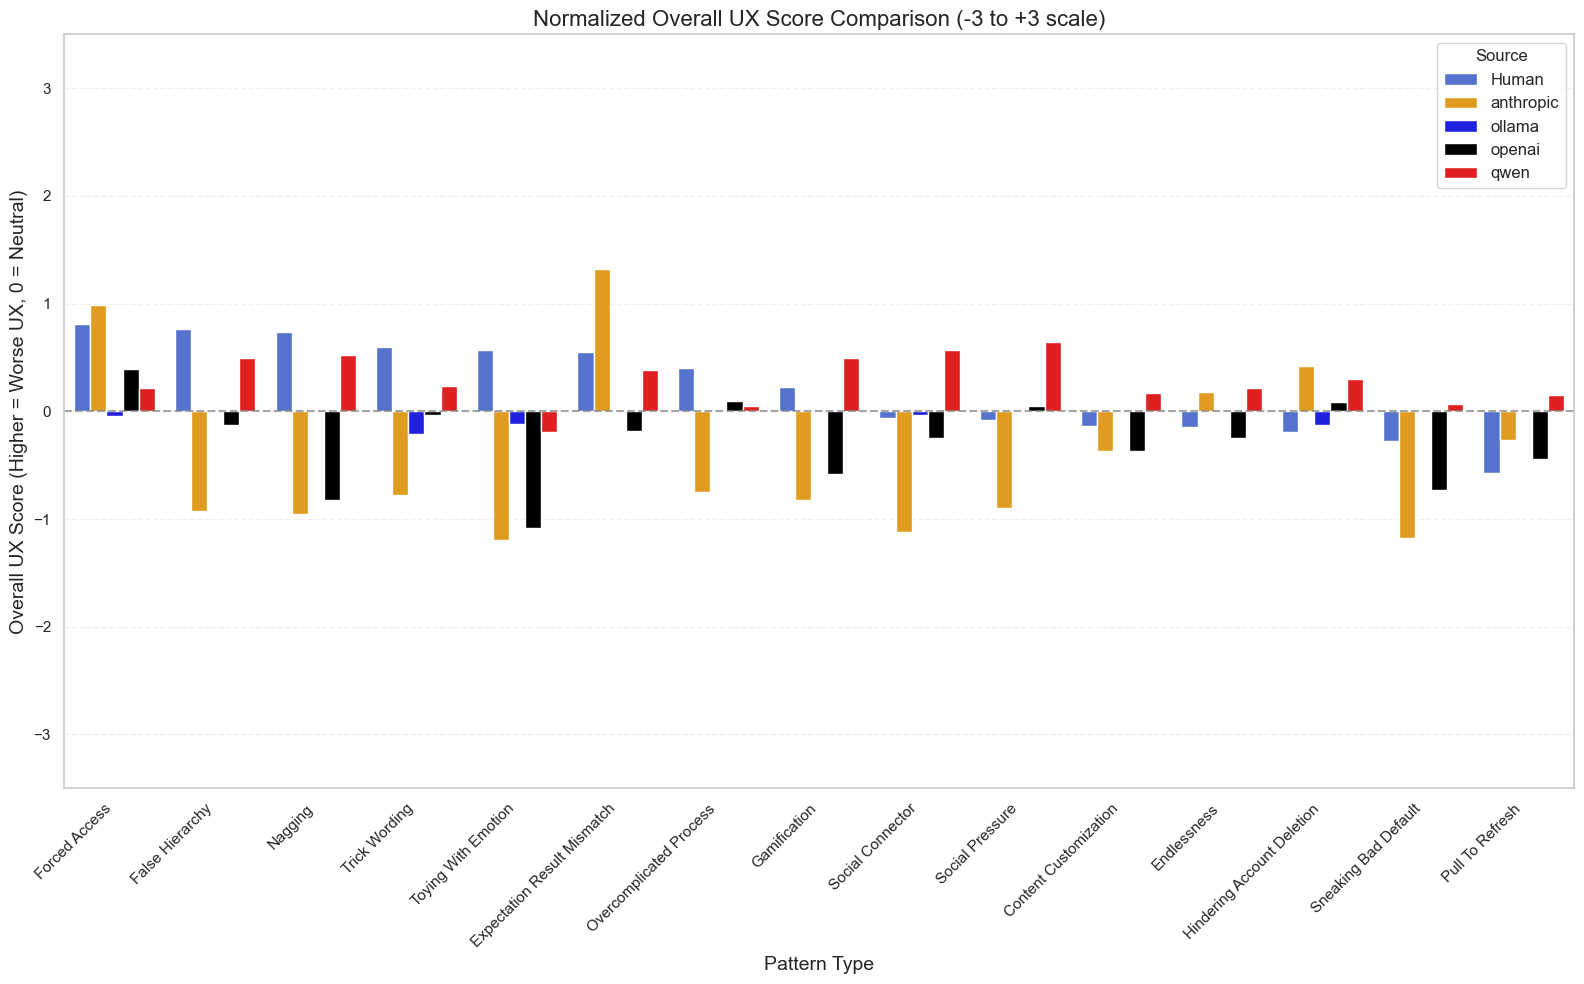


Normalized Overall UX Score Comparison (-3 to +3 scale):
source                       Human  anthropic  ollama  openai  qwen
pattern_type                                                       
Forced Access                 0.81       0.99   -0.05    0.39  0.21
False Hierarchy               0.76      -0.93    0.00   -0.13  0.50
Nagging                       0.74      -0.95    0.00   -0.82  0.52
Trick Wording                 0.60      -0.77   -0.21   -0.04  0.24
Toying With Emotion           0.57      -1.19   -0.12   -1.08 -0.19
Expectation Result Mismatch   0.55       1.32    0.00   -0.18  0.38
Overcomplicated Process       0.40      -0.75    0.00    0.10  0.05
Gamification                  0.23      -0.82    0.00   -0.58  0.50
Social Connector             -0.06      -1.12   -0.04   -0.25  0.57
Social Pressure              -0.08      -0.89    0.00    0.05  0.64
Content Customization        -0.13      -0.37    0.00   -0.37  0.17
Endlessness                  -0.15       0.18    0.00   -0

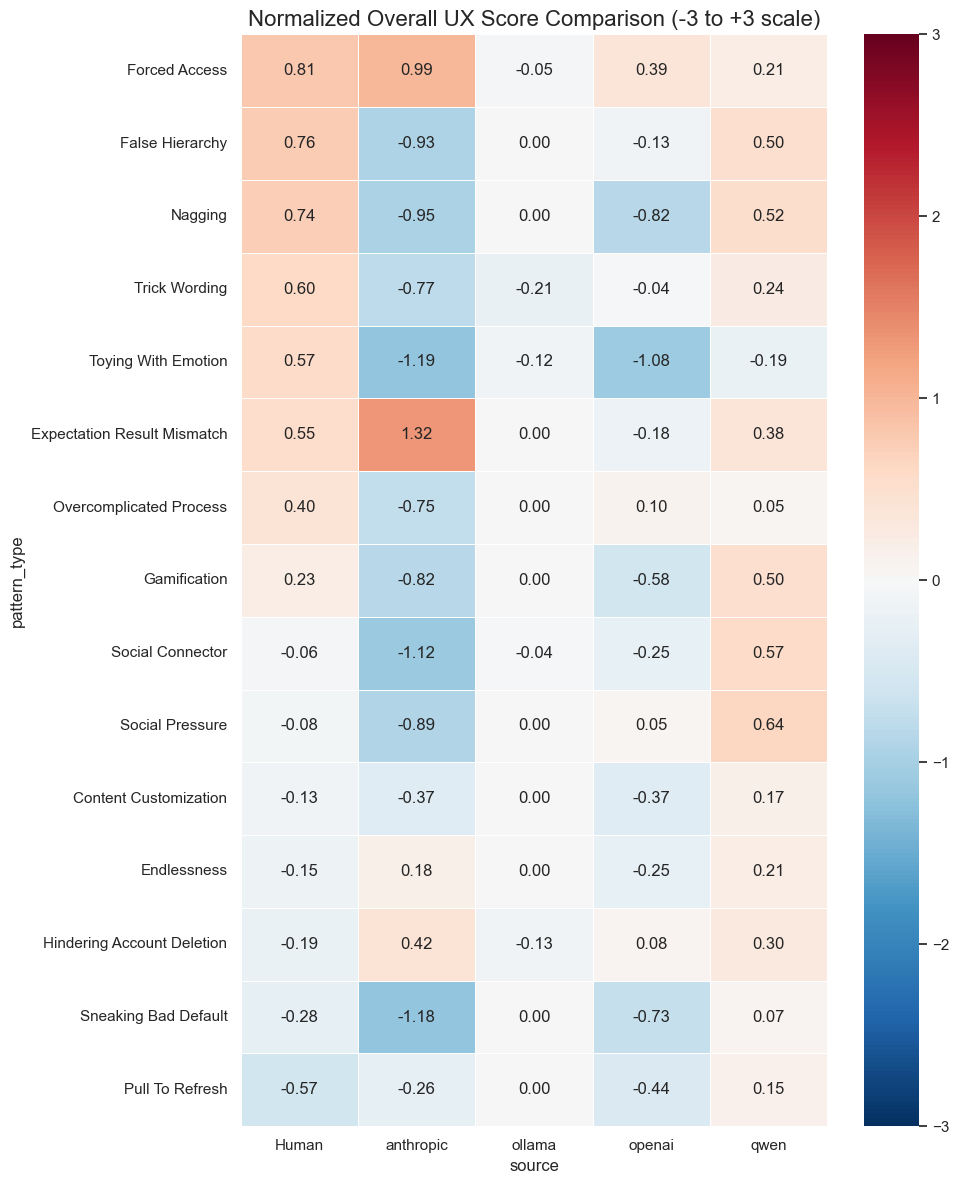

Data saved to results-noleakage-eval_output/normalized_ux_comparison.csv


In [12]:
# Create a normalized overall UX score comparison across all scales
print("Creating normalized overall UX score comparison...")

# Define the function to calculate normalized overall UX score
def calculate_normalized_overall_ux(df):
    """Calculate the mean of all normalized UX scores (-3 to +3 scale)."""
    # Create a copy to avoid modifying the input
    result_df = df.copy()
    
    # Fix the addictive column name for consistency
    if 'score_addictive_non-addictive' in result_df.columns and 'score_addictive_non_addictive' not in result_df.columns:
        result_df['score_addictive_non_addictive'] = result_df['score_addictive_non-addictive']
    
    # Get all score columns
    score_cols = [col for col in result_df.columns if col.startswith('score_')]
    
    # Standardize all scales so higher = worse UX on -3 to +3 scale
    needs_inversion = [
        'score_boring_exciting',
        'score_complicated_easy', 
        'score_inefficient_efficient', 
        'score_unpredictable_predictable',
        'score_pressuring_suggesting',
        'score_deceptive_benevolent',
        'score_addictive_non_addictive'
    ]
    
    # First normalize all scores to -3 to +3 scale
    for col in score_cols:
        result_df[f'norm_{col}'] = result_df[col] - 4  # Convert 1-7 to -3 to +3
    
    # Create standardized versions
    for col in score_cols:
        norm_col = f'norm_{col}'
        if col in needs_inversion:
            # These need to be inverted so high values = negative aspect
            result_df[f'std_{col}'] = -result_df[norm_col]  # Invert sign
        else:
            # These are already oriented so high values = negative aspect
            result_df[f'std_{col}'] = result_df[norm_col]
    
    # Calculate overall UX score (mean of all standardized scales)
    std_cols = [f'std_{col}' for col in score_cols if f'std_{col}' in result_df.columns]
    
    if std_cols:
        result_df['overall_norm_ux'] = result_df[std_cols].mean(axis=1)
    
    return result_df

# Calculate normalized overall UX score for human data
human_norm = calculate_normalized_overall_ux(human_data)
# Calculate normalized overall UX score for model data
model_norm = calculate_normalized_overall_ux(model_data)

# Calculate average overall UX score for each pattern type - Human data
human_pattern_norm = human_norm.groupby('metadata_pattern_type')['overall_norm_ux'].mean().reset_index()
human_pattern_norm = human_pattern_norm.rename(columns={'overall_norm_ux': 'human_overall_ux'})

# Fix the "Pull to Refresh" and "Pull To Refresh" inconsistency
human_pattern_norm['metadata_pattern_type'] = human_pattern_norm['metadata_pattern_type'].replace('Pull to Refresh', 'Pull To Refresh')

# Calculate average overall UX score for each pattern type and model
model_pattern_norm = model_norm.groupby(['metadata_pattern_type', 'metadata_ai_service', 'metadata_model'])['overall_norm_ux'].mean().reset_index()
# Fix pattern names in model data
model_pattern_norm['metadata_pattern_type'] = model_pattern_norm['metadata_pattern_type'].replace('Pull to Refresh', 'Pull To Refresh')

# Print summary of models in the overall UX data
print("\nModels in normalized data:")
print(model_pattern_norm[['metadata_ai_service', 'metadata_model']].drop_duplicates())

# Prepare data for visualization
norm_comparison_data = []

# Add human data
for idx, row in human_pattern_norm.iterrows():
    pattern = row['metadata_pattern_type']
    norm_comparison_data.append({
        'pattern_type': pattern,
        'source': 'Human',
        'model': 'Human',
        'overall_ux': row['human_overall_ux']
    })

# Add model data directly from model_pattern_norm
for idx, row in model_pattern_norm.iterrows():
    pattern = row['metadata_pattern_type']
    service = row['metadata_ai_service']
    model = row['metadata_model']
    
    norm_comparison_data.append({
        'pattern_type': pattern,
        'source': service,
        'model': model,
        'overall_ux': row['overall_norm_ux']
    })

norm_comparison_df = pd.DataFrame(norm_comparison_data)

# Count patterns by source for verification
print("\nPattern counts by source in normalized comparison:")
source_counts = norm_comparison_df.groupby('source')['pattern_type'].count()
print(source_counts)

# Sort by human overall UX score (worst to best)
pattern_order = human_pattern_norm.sort_values('human_overall_ux', ascending=False)['metadata_pattern_type'].tolist()

# Create bar chart with specific color palette for each model
plt.figure(figsize=(16, 10))

# Set up a clear color palette
palette = {'Human': 'royalblue', 'openai': 'black', 'anthropic': 'orange', 'qwen': 'red', 'ollama': 'blue'}

# Create the bar plot with ordered patterns
ax = sns.barplot(
    x='pattern_type', 
    y='overall_ux', 
    hue='source', 
    data=norm_comparison_df, 
    palette=palette,
    order=pattern_order
)

# Add a horizontal line at y=0 (neutral)
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)

# Customize chart
plt.title('Normalized Overall UX Score Comparison (-3 to +3 scale)', fontsize=16)
plt.xlabel('Pattern Type', fontsize=14)
plt.ylabel('Overall UX Score (Higher = Worse UX, 0 = Neutral)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Source', fontsize=12)

# Set y-axis limits to show the full -3 to +3 range
plt.ylim(-3.5, 3.5)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()

# Save figure
plt.savefig(os.path.join(output_dir, 'normalized_overall_ux_comparison.png'))
plt.show()

# Create a pivot table for heatmap
pivot_data = norm_comparison_df.pivot(index='pattern_type', columns='source', values='overall_ux')
# Sort rows by human scores
pivot_data = pivot_data.reindex(pattern_order)

# Display the data
print("\nNormalized Overall UX Score Comparison (-3 to +3 scale):")
print(pivot_data.round(2))

# Create heatmap
plt.figure(figsize=(10, 12))
# Custom diverging colormap centered at 0
sns.heatmap(
    pivot_data, 
    annot=True, 
    cmap='RdBu_r',  # Red-Blue diverging map (reversed)
    center=0,       # Center the colormap at 0
    fmt='.2f', 
    linewidths=.5,
    vmin=-3,        # Set min value
    vmax=3          # Set max value
)
plt.title('Normalized Overall UX Score Comparison (-3 to +3 scale)', fontsize=16)
plt.tight_layout()

# Save heatmap
plt.savefig(os.path.join(output_dir, 'normalized_ux_heatmap.png'))
plt.show()

# Save to CSV
pivot_data.round(2).reset_index().to_csv(os.path.join(output_dir, 'normalized_ux_comparison.csv'), index=False)
print(f'Data saved to {os.path.join(output_dir, 'normalized_ux_comparison.csv')}')